# Inverting gradient attack

In [ ]:
from __future__ import annotations

from copy import deepcopy
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import torch
from torch import nn, Tensor
from torch.nn.modules.loss import _Loss, CrossEntropyLoss
from torch.optim import Optimizer, SGD, Adam
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from torchmetrics.classification import MulticlassAccuracy
from image_classification.nn import Logs
from image_classification.accel import BEST_DEVICE

Using cpu device


## ResNet-18

For quick prototyping, also consider using `ShuffleNetV2`, a 300M-parameter model that is much smaller than `ResNet18`. Experiments can be made on both models or on only one of them.

In [2]:
from image_classification.models import ResNet18, ShuffleNetV2
from image_classification.datasets import cifar10_train_test, cifar100_train_test

In [3]:
# Set to 10 for CIFAR-10, 100 for CIFAR-100
num_classes = 10

# The images are already normalized by theses datasets
if num_classes == 10:
    get_train_test = cifar10_train_test
elif num_classes == 100:
    get_train_test = cifar100_train_test
else:
    raise ValueError(f"Can't find CIFAR dataset with {num_classes} classes")
print(f"Loading CIFAR-{num_classes}")

training_data, test_data = get_train_test(root='data')
N_test = len(test_data)
N_val = len(training_data) // 10
N_aux = N_val
N = len(training_data) - N_val - N_aux
# This works since training data is already shuffled
training_data, val_data, aux_data = training_data.split([N, N_val, N_aux])

batch_size = 100
N, N_val, N_aux, N_test

Loading CIFAR-10


(40000, 5000, 5000, 10000)

In [4]:
train_loader = DataLoader(training_data, batch_size, drop_last=True)
val_loader = DataLoader(val_data, batch_size, drop_last=True)
aux_loader = DataLoader(aux_data, batch_size, drop_last=True)

### Hyperparameters

In [5]:
criterion = CrossEntropyLoss()

## Inverting gradient attack

In [31]:
from importlib import reload
import image_classification.gradient_attack
import inverting_gradient_attack
import federated as fed
reload(image_classification.gradient_attack)
reload(inverting_gradient_attack)
reload(fed)

<module 'federated' from '/home/lvt/dev/python/ml/psc/playground/implementations/projects/poisoning/federated/__init__.py'>

In [32]:
from image_classification.gradient_attack import (
    GradientAttack,
    GradientEstimator, OmniscientGradientEstimator, ShadowGradientEstimator,
    SampleInit, SampleInitRandomNoise, LearningSettings, GradientInverter,
    Schedule, NeverUpdate
)
from inverting_gradient_attack import Pipeline, PipelineResults, Unlearning, Hyperparams
import federated as fed
#from federated import Aggregator, Mean, Krum
from inverting_gradient_attack import Aggregator, Mean, Krum # Avoids failing isinstance checks
from federated.utils import convert_bn_modules_to_gn

## Poisoning + Unlearning pipeline

In [33]:
def patch_network(network_factory: type[nn.Module]):
    """Patches a neural network factory to make it compatible to per-gradient backpropagation.
    
    This replaces a model's BatchNorm layers with GroupNorm.
    See `federated.utils` documentation for technical details.
    """
    def patch():
        return convert_bn_modules_to_gn(network_factory())
    
    return patch

In [34]:
def train(
        model_factory = ResNet18,
        aggregator = Mean(),
        training_hparams: dict = {},
        quicktesting: bool = False,
) -> tuple[nn.Module, Logs]:
    """Train the model normally.
    
    Parameters:
        model_factory (Module type): the neural network class.
        aggregator (Aggregator): a gradient aggregation method.

        training_hparams (dict, optional): training hyperparameter overrides.

        quicktesting (bool, defaults to False): whether to use a small model,
            a smaller subset of the training dataset and less training epochs
            for quicker testing iterations. Overrides hyperparameters when relevant.

    Returns:
        out (tuple[nn.Module, Logs]): the trained model and the training logs.
    """
    settings = LearningSettings(
        criterion,
        aggregator = deepcopy(aggregator),
        num_clean = batch_size,
        num_byzantine = 0,
    )
    hparams = Hyperparams()
    hparams = dataclasses.replace(hparams, **training_hparams)

    if quicktesting:
        model_factory = ShuffleNetV2
        mini_train_set = Subset(training_data, np.arange(N_aux))
        train_loader_ = DataLoader(mini_train_set, batch_size)
        hparams = dataclasses.replace(hparams, epochs=1)
    else:
        train_loader_ = train_loader

    pipeline = Pipeline(settings, train_loader_, val_loader, hparams)
    
    model = patch_network(model_factory)().to(BEST_DEVICE)
    logs = pipeline.train_loop(model)
    return model, logs
    

In [35]:
def poison_and_unlearn(
        model_factory = ResNet18,
        aggregator = Mean(),
        inversion_method = GradientAttack.ASCENT,
        poison_factor: float = 0.2,
        unlearning_method = Unlearning.NEG_GRAD_PLUS,
        training_hparams: dict = {},
        unlearning_hparams: dict = {},
        quicktesting: bool = False,
    ) -> tuple[nn.Module, PipelineResults]:
    """Run the poison-and-unlearn pipeline with default settings.

    Parameters:
        model_factory (Module type): the neural network class.
        inversion_method (GradientAttack): the gradient inversion method.
        poison_factor (float): the proportion of poisons in the training data.
        aggregator (Aggregator): a gradient aggregation method.
        unlearning_method (Unlearning): the unlearning algorithm.

        training_hparams (dict, optional): training hyperparameter overrides.
        unlearning_hparams (dict, optional): unlearning hyperparameter overrides.

        quicktesting (bool, defaults to False): whether to use a small model,
            a smaller subset of the training dataset and less training epochs
            for quicker testing iterations. Overrides hyperparameters when relevant.

    Returns:
        out (tuple[nn.Module, PipelineResults]): the unlearner and the pipeline results.
    """
    inverter = GradientInverter(
        method = inversion_method,
        estimator = ShadowGradientEstimator(aux_loader),
        steps = 5,
        sample_init = SampleInitRandomNoise(training_data),
    )
    settings = LearningSettings(
        criterion,
        aggregator = deepcopy(aggregator),
        num_clean = batch_size,
        num_byzantine = int(poison_factor / (1. - poison_factor) * batch_size),
    )
    hparams = Hyperparams()
    hparams = dataclasses.replace(hparams, **training_hparams)

    if quicktesting:
        model_factory = ShuffleNetV2
        mini_train_set = Subset(training_data, np.arange(N_aux))
        train_loader_ = DataLoader(mini_train_set, batch_size)
        hparams = dataclasses.replace(hparams, epochs=1)
    else:
        train_loader_ = train_loader

    pipeline = Pipeline(settings, train_loader_, val_loader, hparams)
    pipeline.unlearning_hparams[unlearning_method].update(unlearning_hparams)
    
    model = patch_network(model_factory)().to(BEST_DEVICE)
    unlearner, results = pipeline.poison_and_unlearn(model, inverter, unlearning_method)
    # Now model is the poisoned model without unlearning
    return unlearner, results

In [36]:
def make_robust_aggregator(batch_size: int, alpha: float) -> Krum:
    """Configure a robust aggregation method.

    Parameters:
        batch_size (int): the clean data batch size.
            Warning : this is not the true batch size since it does not include poisons,
            the latter are artificially inserted into the batch.
        alpha (float): the maximum proportion of poisons to defend against.

    Returns:
        aggregator (Krum): a robust aggregator.
    """
    alpha = 0.1
    f = int(alpha / (1 - alpha) * batch_size)
    n = batch_size + f
    m = n - (2 * f + 3)
    return Krum(f, m)

In [37]:
unlearner, results = train(
    ShuffleNetV2,
    aggregator = make_robust_aggregator(batch_size, alpha = 0.1),
    training_hparams = dict(epochs=1),
    quicktesting=True,
)

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)


Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 5000/5000 [00:11<00:00, 441.26it/s, accuracy=0.108, avg_loss=2.35]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:03<00:00, 1510.29it/s, accuracy=0.0994, avg_loss=2.29]


In [38]:
unlearner, results = poison_and_unlearn(
    ShuffleNetV2,
    aggregator = make_robust_aggregator(batch_size, alpha = 0.1),
    inversion_method = GradientAttack.ASCENT,
    poison_factor = 0.05,
    unlearning_method = Unlearning.NEG_GRAD_PLUS,
    training_hparams = dict(epochs=1),
    unlearning_hparams = dict(),
    quicktesting=True,
)

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 5000/5000 [01:59<00:00, 41.90it/s, accuracy=0.1, avg_loss=4.09]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:03<00:00, 1443.64it/s, accuracy=0.1, avg_loss=2.53]


NegGrad+ epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

NegGrad+:   0%|          | 0/50 [00:00<?, ?it/s]

In [39]:
def display_results(results: PipelineResults):
    # Mean accuracy per step
    # TODO: plot moving average or epoch tracking average instead
    accuracy_per_step = torch.cat([
        epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
        for epoch_metrics in results.train_logs.train_metrics
    ])
    plt.plot(np.arange(len(accuracy_per_step)), accuracy_per_step)
    plt.xlabel("Step")
    plt.ylabel("Mean accuracy")
    plt.ylim((0.0, 1.0))
    plt.title("Training accuracy (poisoning)")
    plt.show()

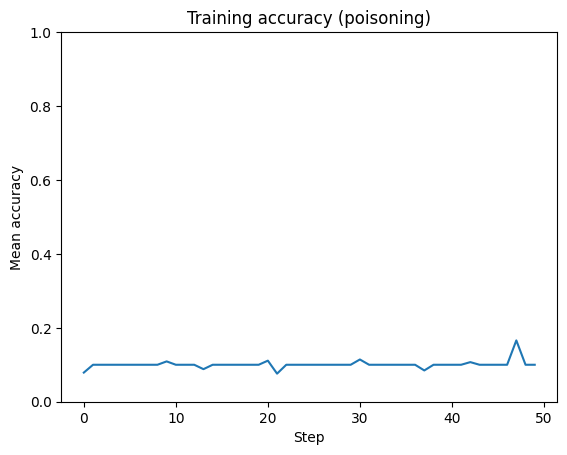

In [40]:
display_results(results)